This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Hydrometeor partitioning ratio retrievals for Ground Radar

In this notebook, measurements from NEXRAD's KDDC ground radar are used to derive Hydrometeor Partitioning Ratios (HPR) following Pejcic et al. 2025 (in review). This requires the horizontal reflectivity, differential reflectivity, specific differential phase, cross correlation coefficient, temperature information and rain type. The temperature information is derived from sounding and a rain type classification is applied following Park et al. The HPRs for the different hydrometeor classes are then presented. 

In [1]:
import wradlib as wrl
import wradlib_data
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()  

import glob
import xarray as xr
import datetime as dt
import xradar as xd
import scipy

## Read centroids, covariances and weights

In [2]:
cdp_file = wradlib_data.DATASETS.fetch("misc/hmcp_centroids_dp.nc")
with xr.open_dataset(cdp_file) as cdp:
    pass
cdp

<xarray.Dataset> Size: 3kB
Dimensions:  (hmc: 11, obs: 5, obscov: 5)
Coordinates:
  * obs      (obs) <U3 60B 'ZH' 'ZDR' 'KDP' 'RHO' 'RT'
  * hmc      (hmc) <U2 88B 'LR' 'MR' 'HR' 'BD' 'RH' ... 'IC' 'WS' 'SN' 'DP' 'DH'
Dimensions without coordinates: obscov
Data variables:
    ave      (hmc, obs) float64 440B ...
    cov      (hmc, obs, obscov) float64 2kB ...
Attributes:
    title:        NEXRAD data based centroids and covariances for specific hy...
    institution:  Institute of Geosciences, Meteorology Section, University o...
    source:       Dual polarimetric quality control for NASA’s Global Precipi...
    version:      1
    history:      NEXRAD data based centroids and covariances for specific hy...
    references:   .
    comment:      Created with wradlib.

In [3]:
weights_file = wradlib_data.DATASETS.fetch("misc/hmcp_weights.nc")
with xr.open_dataset(weights_file) as cw:
    pass
cw

<xarray.Dataset> Size: 6kB
Dimensions:  (hmc: 11, temp: 58)
Coordinates:
  * temp     (temp) int64 464B -80 -78 -76 -74 -72 -70 -68 ... 24 26 28 30 32 34
  * hmc      (hmc) <U2 88B 'LR' 'MR' 'HR' 'BD' 'RH' ... 'IC' 'WS' 'SN' 'DP' 'DH'
Data variables:
    weights  (hmc, temp) float64 5kB ...
Attributes:
    title:        NEXRAD data based weights for specific hydrometeor classes ...
    institution:  Institute of Geosciences, Meteorology Section, University o...
    source:       Dual polarimetric quality control for NASA’s Global Precipi...
    version:      1
    history:      NEXRAD data based weights for specific hydrometeor classes ...
    references:   .
    comment:      Created with wradlib.

## Read polarimetric radar observations

In [4]:
volume = wradlib_data.DATASETS.fetch("netcdf/KDDC_2018_0625_051138_min.cf")
gr_data = xd.io.open_cfradial1_datatree(volume)
gr_data

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 14, frequency: 1)
│   Coordinates:
│     * frequency            (frequency) float32 4B 2.998e+09
│   Dimensions without coordinates: sweep
│   Data variables:
│       altitude             float64 8B ...
│       sweep_fixed_angle    (sweep) float32 56B ...
│       instrument_type      |S32 32B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       platform_type        |S32 32B ...
│       primary_axis         |S32 32B ...
│       sweep_group_name     (sweep) <U8 448B 'sweep_0' 'sweep_1' ... 'sweep_13'
│       time_coverage_end    |S32 32B ...
│       time_coverage_start  |S32 32B ...
│       volume_number        int32 4B ...
│   Attributes:
│       Conventions:         CF/Radial instrument_parameters radar_parameters
│       title:               
│       institution:         NASA GSFC
│       references:          https://github.com/GPM-GV/GVradar
│       source:              GVradar V1.1
│       comment:             
│       instrument_name:     KDDC
│       site_name:           KDDC
│       platform_is_mobile:  false
│       ray_times_increase:  true
│       version:             VN V2.1
│       history:             Mon Mar 10 10:45:42 2025: ncks -x -v DZ,PH,VR,SW,SD,...
├── Group: /sweep_0
│       Dimensions:            (azimuth: 720, range: 1832)
│       Coordinates:
│         * azimuth            (azimuth) float32 3kB 0.2656 0.75 1.203 ... 359.3 359.7
│           elevation          (azimuth) float32 3kB ...
│         * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
│           time               (azimuth) datetime64[ns] 6kB 2018-06-25T05:11:51 ... 2...
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│           altitude           float64 8B ...
│       Data variables:
│           CZ                 (azimuth, range) float32 5MB ...
│           DR                 (azimuth, range) float32 5MB ...
│           KD                 (azimuth, range) float32 5MB ...
│           RH                 (azimuth, range) float32 5MB ...
│           sweep_fixed_angle  float32 4B ...
│           nyquist_velocity   (azimuth) float32 3kB ...
│           prt                (azimuth) float32 3kB ...
│           pulse_width        (azimuth) float32 3kB ...
│           scan_rate          (azimuth) float32 3kB ...
│           sweep_mode         <U20 80B 'azimuth_surveillance'
│           sweep_number       int32 4B ...
│           unambiguous_range  (azimuth) float32 3kB ...
├── Group: /sweep_1
│       Dimensions:            (azimuth: 720, range: 1832)
│       Coordinates:
│         * azimuth            (azimuth) float32 3kB 0.25 0.7656 1.25 ... 359.2 359.7
│           elevation          (azimuth) float32 3kB ...
│         * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
│           time               (azimuth) datetime64[ns] 6kB 2018-06-25T05:12:32 ... 2...
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│           altitude           float64 8B ...
│       Data variables:
│           CZ                 (azimuth, range) float32 5MB ...
│           DR                 (azimuth, range) float32 5MB ...
│           KD                 (azimuth, range) float32 5MB ...
│           RH                 (azimuth, range) float32 5MB ...
│           sweep_fixed_angle  float32 4B ...
│           nyquist_velocity   (azimuth) float32 3kB ...
│           prt                (azimuth) float32 3kB ...
│           pulse_width        (azimuth) float32 3kB ...
│           scan_rate          (azimuth) float32 3kB ...
│           sweep_mode         <U20 80B 'azimuth_surveillance'
│           sweep_number       int32 4B ...
│           unambiguous_range  (azimuth) float32 3kB ...
├── Group: /sweep_2
│       Dimensions:            (azimuth: 720, range: 1832)
│       Coordinates:
│         * azimuth            (azimuth) float32 3kB 0.

## Get Temperature Profile

We would need the temperature of each radar bin. For that, we use Sounding Data. We also set the max_height to 30km and interpolate the vertical profile with a resolution of 1m.

In [5]:
rs_time = dt.datetime.fromisoformat(
    str(gr_data.time_coverage_start.values.item().decode())
)
wmoid = 72451
import urllib

try:
    rs_ds = wrl.io.get_radiosonde(
        wmoid, rs_time, cols=np.arange(13), xarray=True, max_height=30000.0, res=1.0
    )
except (urllib.error.HTTPError, urllib.error.URLError):
    print("service down")
    dataf = wradlib_data.DATASETS.fetch("misc/radiosonde_72451_20180625_0000.h5")
    rs_data, _ = wrl.io.from_hdf5(dataf)
    metaf = wradlib_data.DATASETS.fetch("misc/radiosonde_72451_20180625_0000.json")
    with open(metaf, "r") as infile:
        import json

        rs_meta = json.load(infile)
    rs_ds = wrl.io.radiosonde_to_xarray(
        rs_data, meta=rs_meta, max_height=30000.0, res=1.0
    )

In [6]:
display(rs_ds)

<xarray.Dataset> Size: 3MB
Dimensions:  (HGHT: 30001)
Coordinates:
  * HGHT     (HGHT) float64 240kB 0.0 1.0 2.0 3.0 ... 3e+04 3e+04 3e+04 3e+04
Data variables:
    PRES     (HGHT) float64 240kB 920.0 920.0 920.0 920.0 ... 12.45 12.45 12.44
    TEMP     (HGHT) float64 240kB 26.0 26.0 26.0 26.0 ... -41.63 -41.63 -41.63
    DWPT     (HGHT) float64 240kB 16.0 16.0 16.0 16.0 ... -78.16 -78.16 -78.16
    FRPT     (HGHT) float64 240kB 16.0 16.0 16.0 16.0 ... -73.92 -73.92 -73.91
    RELH     (HGHT) float64 240kB 54.0 54.0 54.0 54.0 54.0 ... 1.0 1.0 1.0 1.0
    RELI     (HGHT) float64 240kB 54.0 54.0 54.0 54.0 54.0 ... 1.0 1.0 1.0 1.0
    MIXR     (HGHT) float64 240kB 12.58 12.58 12.58 12.58 ... 0.07 0.07 0.07
    DRCT     (HGHT) float64 240kB 100.0 100.0 100.0 100.0 ... 64.02 63.85 63.69
    SKNT     (HGHT) float64 240kB 4.0 4.0 4.0 4.0 ... 18.42 18.42 18.42 18.43
    THTA     (HGHT) float64 240kB 306.4 306.4 306.4 306.4 ... 810.4 810.4 810.5
    THTE     (HGHT) float64 240kB 344.5 344.5 344.5 344.5 ... 811.3 811.3 811.3
    THTV     (HGHT) float64 240kB 308.7 308.7 308.7 308.7 ... 810.4 810.4 810.5
Attributes: (12/32)
    Station identifier:                           DDC
    Station number:                               72451
    Observation time:                             2018-06-25 00:00:00
    Station latitude:                             37.76
    Station longitude:                            -99.97
    Station elevation:                            790.0
    ...                                           ...
    Equivalent potential temp [K] of the LCL:     340.04
    Mean mixed layer potential temperature:       305.79
    Mean mixed layer mixing ratio:                11.36
    1000 hPa to 500 hPa thickness:                5789.0
    Precipitable water [mm] for entire sounding:  26.16
    quantity:                                     {'PRES': 'hPa', 'HGHT': 'm'...

## Plot Temperature Profile

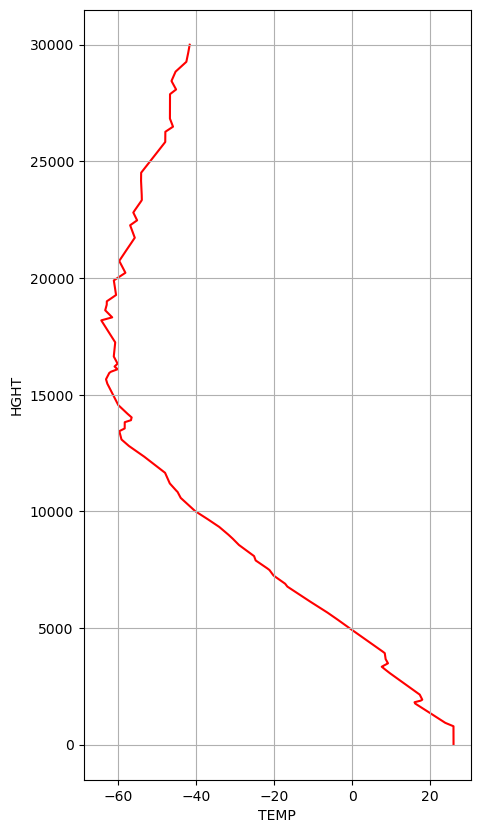

In [7]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)
rs_ds.TEMP.plot(y="HGHT", ax=ax, zorder=0, c="r")
ax.grid(True)

## get freezing level height

We need to obtain the freezing level height, which is needed for an ad-hoc retrieval of raintype.

In [8]:
fl = np.abs(rs_ds).argmin("HGHT").TEMP
display(fl)

<xarray.DataArray 'TEMP' ()> Size: 8B
array(4914)

## georeference DataTree

For the interpolation of the temperature sounding data onto the radar sweeps, we need the xyz coordinates of the sweeps.

In [9]:
gr_data2 = gr_data.xradar.georeference()

In [10]:
gr_data2["sweep_0"]

<xarray.DataTree 'sweep_0'>
Group: /sweep_0
    Dimensions:            (sweep: 14, frequency: 1, azimuth: 720, range: 1832)
    Coordinates:
      * azimuth            (azimuth) float32 3kB 0.2656 0.75 1.203 ... 359.3 359.7
        elevation          (azimuth) float32 3kB 0.4844 0.4844 ... 0.4844 0.4844
      * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
        time               (azimuth) datetime64[ns] 6kB 2018-06-25T05:11:51 ... 2...
        latitude           float64 8B 37.76
        longitude          float64 8B -99.97
        altitude           float64 8B 789.0
        crs_wkt            int64 8B 0
        x                  (azimuth, range) float64 11MB 9.85 11.01 ... -2.129e+03
        y                  (azimuth, range) float64 11MB 2.125e+03 ... 4.592e+05
        z                  (azimuth, range) float64 11MB 807.2 809.4 ... 1.711e+04
    Inherited coordinates:
      * frequency          (frequency) float32 4B 2.998e+09
    Dimensions without coordinates: sweep
    Data variables:
        CZ                 (azimuth, range) float32 5MB ...
        DR                 (azimuth, range) float32 5MB ...
        KD                 (azimuth, range) float32 5MB ...
        RH                 (azimuth, range) float32 5MB ...
        sweep_fixed_angle  float32 4B ...
        nyquist_velocity   (azimuth) float32 3kB ...
        prt                (azimuth) float32 3kB ...
        pulse_width        (azimuth) float32 3kB ...
        scan_rate          (azimuth) float32 3kB ...
        sweep_mode         <U20 80B 'azimuth_surveillance'
        sweep_number       int32 4B ...
        unambiguous_range  (azimuth) float32 3kB ...

## Interpolate Temperature onto sweeps

The following function interpolates the vertical temperature profile onto the radar sweeps.

In [11]:
def merge_radar_profile(rds, cds):
    if "z" in rds.coords:
        cds = cds.interp({"HGHT": rds.z}, method="linear")
        rds = rds.assign({"TEMP": cds})
    return rds


gr_data3 = gr_data2.map_over_datasets(merge_radar_profile, rs_ds.TEMP)

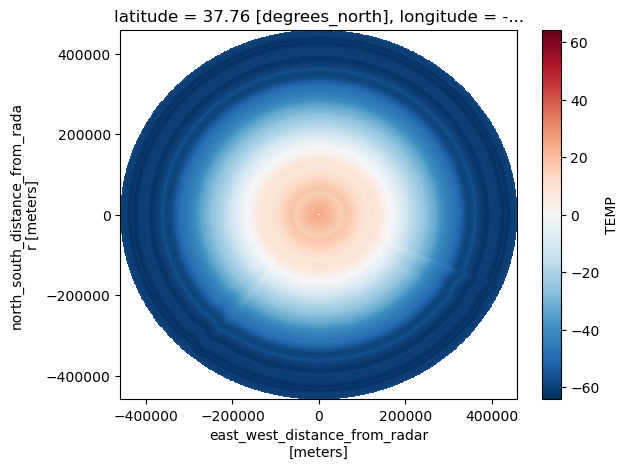

In [12]:
gr_data3["sweep_1"].TEMP.plot(x="x", y="y")

## Ad-hoc retrieval of raintype

The following algorithm of raintype estimation is derived after ([Park et al.](https://doi.org/10.1175/2008WAF2222205.1)).

1. keep all radar bins >= 45 dBZ
1. keep all radar bins > 30 dBZ and height > fl + 1600m
1. combine 1 and 2
1. iterate over x,y pairs and fetch from whole tree to set as convective.

In [13]:
def mask_data(rds, fl):
    if "z" in rds.coords:
        # Thresholding and smoothing (Park et al.)
        # -----------------------------------------
        xwin_zh = 5
        rds = rds.where(rds.RH > 0.8)
        rds["CZ"] = rds.CZ.rolling(
            range=xwin_zh, min_periods=xwin_zh // 2, center=True
        ).mean(skipna=True)
        mask = (rds.CZ >= 45) | ((rds.CZ > 30) & (rds.z > (fl + 1600)))
        rds = rds.assign(mask=mask)
    return rds


gr_data4 = gr_data3.map_over_datasets(mask_data, fl)

## Extract xyz bin coordinates

This iterates over the whole DataTree and extracts the RainType-mask as 1-dimensional array. This keeps only valid values.

In [14]:
def get_xyz(tree):
    swp_list = []
    for key in list(tree.children):
        if "sweep" in key:
            ds = tree[key].ds.stack(npoints=("azimuth", "range"))
            ds = ds.reset_coords().where(ds.mask, drop=True)
            swp_list.append(ds.mask)
    return xr.concat(swp_list, "npoints")

# Interpolation of RainType mask

This interpolates the RainType for all sweeps, to get a vertically consistent RainType.
For this a KDTree is created containing the valid values from above, which is used for the Nearest interpolator.
The ROI (maxdist) is assumed to be the current range resolution, but can be specified as keyword argument.

In [15]:
%%time
from scipy import spatial

kwargs = dict(balanced_tree=True)
xyz = get_xyz(gr_data4)
src = np.vstack([xyz.x.values, xyz.y.values]).T
kdtree = spatial.KDTree(src, **kwargs)


def get_range_res(rng):
    return rng.range.diff("range").median("range").values


def ipol_mask(swp, xyz, kdtree, maxdist=None):
    if "z" in swp.coords:
        if maxdist is None:
            maxdist = swp.range.attrs.get(
                "meters_between_gates", get_range_res(swp.range)
            )
        trg = np.vstack([swp.x.values.ravel(), swp.y.values.ravel()]).T
        nn = wrl.ipol.Nearest(kdtree, trg)
        out = nn(xyz.values, maxdist=maxdist).reshape(swp.x.shape)
        swp = swp.assign(rt=(swp.x.dims, out))
        swp["rt"] = xr.where(swp["rt"] == 1, 2, 1)
    return swp


gr_data5 = gr_data4.map_over_datasets(ipol_mask, xyz, kdtree)

CPU times: user 15.2 s, sys: 418 ms, total: 15.7 s
Wall time: 15.7 s


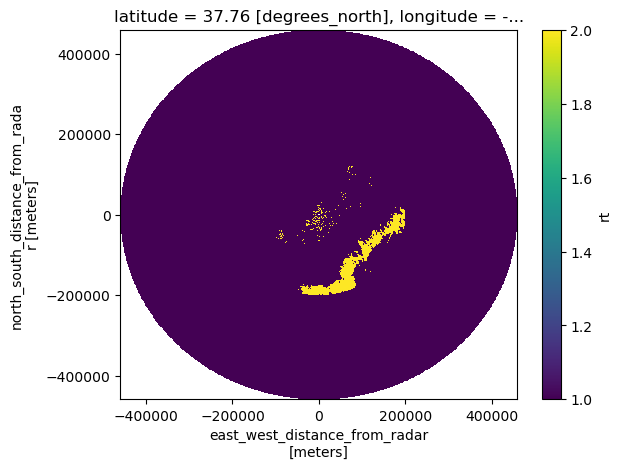

In [16]:
gr_data5["sweep_0"].rt.plot(x="x", y="y")

## ZDR Offset retrieval

The ZDR offset was retrieved following [A. Ryzhkov & D. Zrnic 2019, 6.2.3 Z-ZDR Consistency in Light Rain, pp. 153-156](https://doi.org/10.1007/978-3-030-05093-1).

In [17]:
zdr_offset = 0.5

## Extract sweep 2 for further processing

In [18]:
swp = gr_data5["sweep_2"].ds
swp

<xarray.DatasetView> Size: 139MB
Dimensions:            (azimuth: 720, range: 1832, frequency: 1)
Coordinates: (12/13)
  * frequency          (frequency) float32 4B 2.998e+09
  * azimuth            (azimuth) float32 3kB 0.2656 0.7344 1.219 ... 359.2 359.7
    elevation          (azimuth) float32 3kB 1.312 1.312 1.312 ... 1.312 1.312
  * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
    time               (azimuth) datetime64[ns] 6kB 2018-06-25T05:13:13 ... 2...
    latitude           float64 8B 37.76
    ...                 ...
    altitude           float64 8B 789.0
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float64 11MB 9.848 11.01 ... -2.377e+03
    y                  (azimuth, range) float64 11MB 2.124e+03 ... 4.587e+05
    z                  (azimuth, range) float64 11MB 837.9 843.7 ... 2.374e+04
    HGHT               (azimuth, range) float64 11MB 837.9 843.7 ... 2.374e+04
Data variables: (12/15)
    CZ                 (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    DR                 (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    KD                 (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    RH                 (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    sweep_fixed_angle  (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    nyquist_velocity   (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    ...                 ...
    sweep_mode         (azimuth, range) object 11MB nan nan nan ... nan nan nan
    sweep_number       (azimuth, range) float64 11MB nan nan nan ... nan nan nan
    unambiguous_range  (azimuth, range) float32 5MB nan nan nan ... nan nan nan
    TEMP               (azimuth, range) float64 11MB nan nan nan ... nan nan nan
    mask               (azimuth, range) bool 1MB False False ... False False
    rt                 (azimuth, range) int64 11MB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

<xarray.Dataset> Size: 63MB
Dimensions:    (azimuth: 720, range: 1832)
Coordinates:
  * azimuth    (azimuth) float32 3kB 0.2656 0.7344 1.219 ... 358.7 359.2 359.7
    elevation  (azimuth) float32 3kB 1.312 1.312 1.312 ... 1.312 1.312 1.312
  * range      (range) float32 7kB 2.125e+03 2.375e+03 ... 4.596e+05 4.599e+05
    time       (azimuth) datetime64[ns] 6kB 2018-06-25T05:13:13 ... 2018-06-2...
    latitude   float64 8B 37.76
    longitude  float64 8B -99.97
    altitude   float64 8B 789.0
    crs_wkt    int64 8B 0
    x          (azimuth, range) float64 11MB 9.848 11.01 ... -2.377e+03
    y          (azimuth, range) float64 11MB 2.124e+03 2.374e+03 ... 4.587e+05
    z          (azimuth, range) float64 11MB 837.9 843.7 ... 2.372e+04 2.374e+04
    HGHT       (azimuth, range) float64 11MB 837.9 843.7 ... 2.372e+04 2.374e+04
Data variables:
    CZ         (azimuth, range) float32 5MB nan nan nan nan ... nan nan nan nan
    DR         (azimuth, range) float32 5MB nan nan nan nan ... nan nan nan nan
    KD         (azimuth, range) float32 5MB nan nan nan nan ... nan nan nan nan
    RH         (azimuth, range) float32 5MB nan nan nan nan ... nan nan nan nan

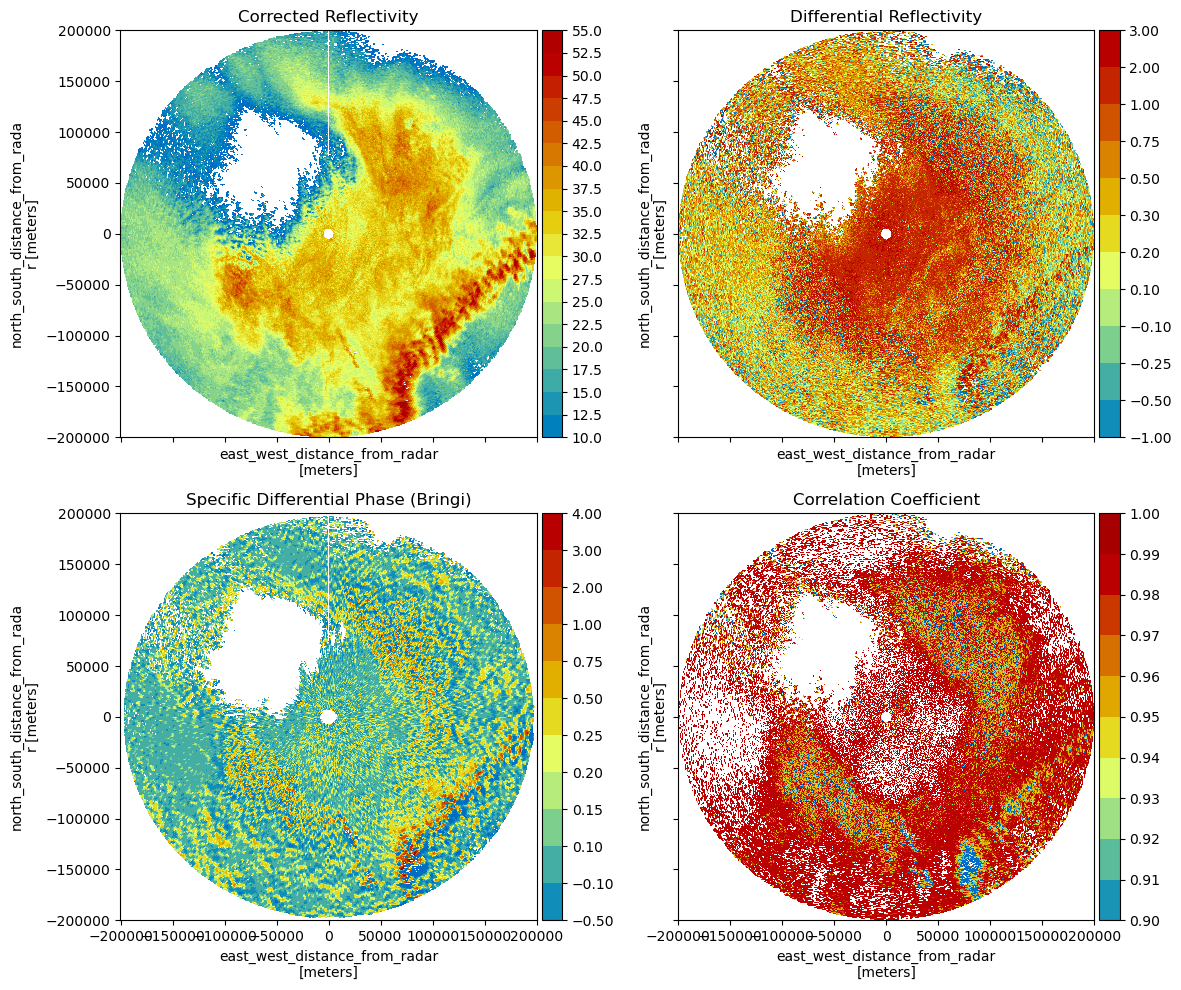

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
swpp = swp[["CZ", "DR", "KD", "RH"]]
display(swpp)

LVL = [
    np.arange(10, 57.5, 2.5),
    np.array([-1, -0.5, -0.25, -0.1, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 2, 3]),
    np.array(
        [-0.5, -0.1, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1, 2, 3, 4]
    ),  # np.arange(-0.5,2, 0.2),
    np.arange(0.9, 1.01, 0.01),
]

for i, var in enumerate(swpp.data_vars.values()):
    cbar_kwargs = {
        "extend": "neither",
        "label": "",
        "pad": 0.01,
        "ticks": LVL[i],
    }
    ax = axs.flat[i]
    var.dropna("range", how="all").plot(
        x="x",
        y="y",
        ax=ax,
        cmap="HomeyerRainbow",
        levels=LVL[i],
        cbar_kwargs=cbar_kwargs,
    )
    ax.set_title(var.attrs["long_name"])

plt.tight_layout()

## Combine observations into xr.DataArray

Use the mapping to bind the existing variable names to the needed names.

In [20]:
# mapping observations
obs_mapping = {
    "ZH": "CZ",
    "ZDR": "DR",
    "KDP": "KD",
    "RHO": "RH",
    "RT": "rt",
    "TEMP": "TEMP",
}
polars = wrl.classify.create_gr_observations(swp, obs_mapping)
polars

<xarray.DataArray 'data' (obs: 6, azimuth: 720, range: 1832)> Size: 63MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(6, 720, 1832))
Coordinates: (12/13)
  * azimuth    (azimuth) float32 3kB 0.2656 0.7344 1.219 ... 358.7 359.2 359.7
    elevation  (azimuth) float32 3kB 1.312 1.312 1.312 ... 1.312 1.312 1.312
  * range      (range) float32 7kB 2.125e+03 2.375e+03 ... 4.596e+05 4.599e+05
    time       (azimuth) datetime64[ns] 6kB 2018-06-25T05:13:13 ... 2018-06-2...
    latitude   float64 8B 37.76
    longitude  float64 8B -99.97
    ...         ...
    crs_wkt    int64 8B 0
    x          (azimuth, range) float64 11MB 9.848 11.01 ... -2.377e+03
    y          (azimuth, range) float64 11MB 2.124e+03 2.374e+03 ... 4.587e+05
    z          (azimuth, range) float64 11MB 837.9 843.7 ... 2.372e+04 2.374e+04
    HGHT       (azimuth, range) float64 11MB 837.9 843.7 ... 2.372e+04 2.374e+04
  * obs        (obs) <U4 96B 'ZH' 'ZDR' 'KDP' 'RHO' 'RT' 'TEMP'

# Calculate hydrometeor partitioning ratios (HPR)

This uses the loaded weights and centroids to retrieve the hydrometeor partitioning ratio from the observations.

In [21]:
hmpr = wrl.classify.calculate_hmpr(polars, cw.weights, cdp)

## Plotting all Hydrometeor-Classes

For better plotting we transfrom to 100% and drop NaN data.

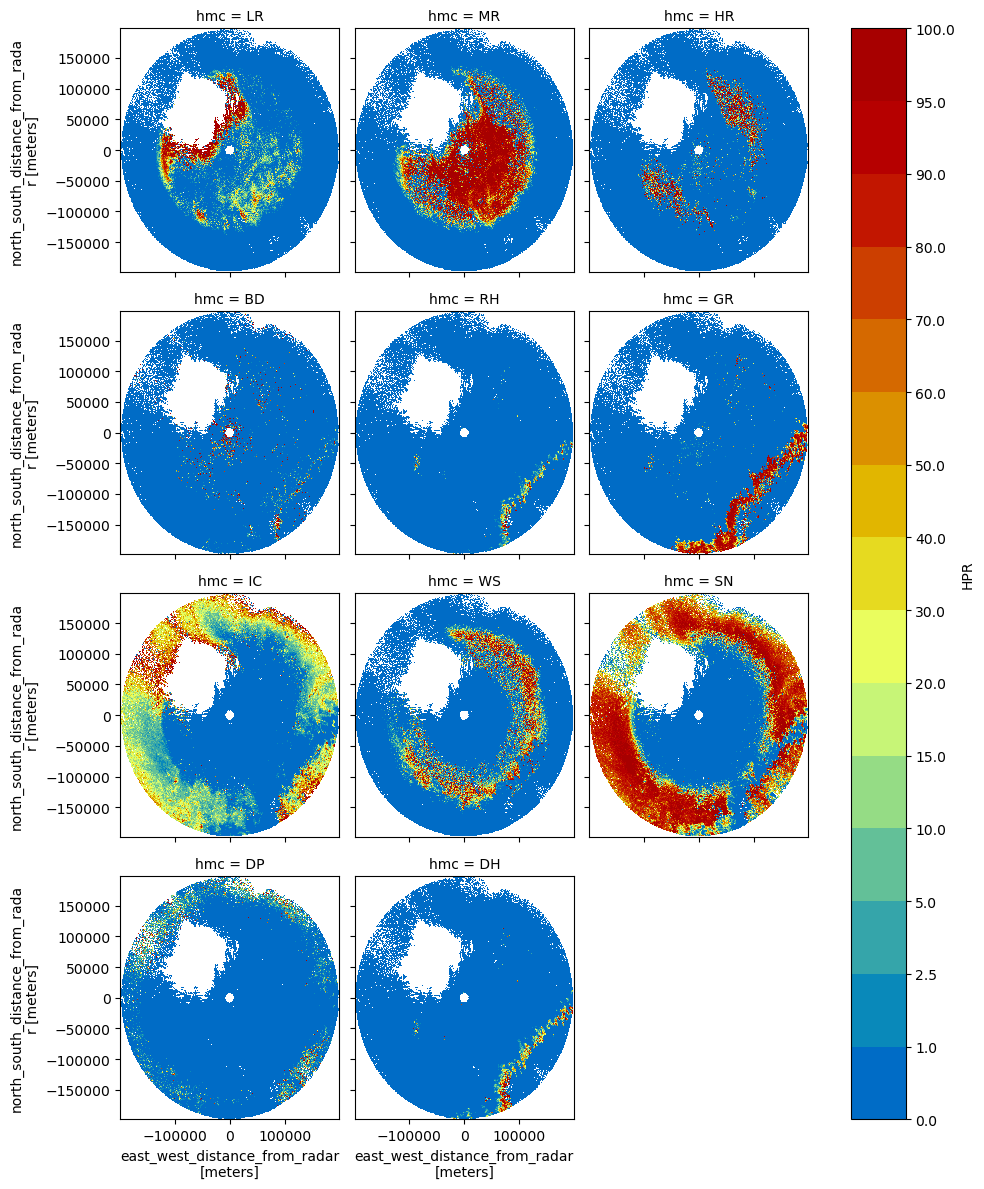

In [22]:
hmpr = hmpr.dropna("range", how="all") * 100
hpr_bins = [0, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]

hmpr.plot(
    col="hmc",
    col_wrap=3,
    x="x",
    y="y",
    cmap="HomeyerRainbow",
    levels=hpr_bins,
    cbar_kwargs={"ticks": hpr_bins},
)